## Note dell'autrice
il codice ritorna il dataframe corrispondente alla partita inserita come input. Gli attributi sono:
- la mossa fatta
- il tempo dell'orologio del singolo giocatore al momento della mossa
- il tempo totale trascorso dall'inizio della partita fino al momento in cui la mossa è stata fatta
- evaluation della posizione dal punto di vista del bianco (quindi quando positiva rappresenta una posizione di vantaggio del bianco, se negativa rappresenta una posizione di vantaggio del nero)

L'evaluation delle mosse che non sono scacchi è data in centipawns e indica la differenza tra la mossa migliore data dal motore e quella effettuata, e dividendo per 100 (non me lo sono inventato io, l'ho trovato su internet) è corrispondente quasi perfettamente a quella visibile per esempio su chess.com.
Per questo nel metodo get_evaluation c'è la condizione per capire se la mossa sia mate o no.

L'unica incertezza riguarda gli scacchi (visibili nel dataframe perchè hanno davanti #), dove non riesco a interpretare l'evaluation, che dovrebbe essere molto più alta e soprattutto non essere decrescente nelle ultime mosse della partita che hanno portato alla vittoria del bianco (nella partita che gli ho passato come input per il test finale "valesepicacchi_vs_dmac5555_2022.05.07 (1).pgn").
Se capite perchè e come dare un punteggio che sia coerente con l'imminente vittoria ditemelo e aggiungetelo.

Altro problema è la libreria di stockfish, che se importavo normalmente e mettevo la directory di dove si trovava mi dava un errore nel testo molto strano, quindi sono stata costretta ad aggiungerla nel folder e così per motivi misteriosi funziona. In questa riga di codice (stockfish = Stockfish()) della seconda cella se non viene passato un parametro va automaticamente a cercare nel folder un file executable che si chiami stockfish e quindi non mi da problemi. Anche questa riga (engine = chess.engine.SimpleEngine.popen_uci("stockfish")) sempre della seconda cella funziona solo in questo modo. Ovviamente il file stockfish.exe è la libreria per windows quindi non credo funzionerà per un mac. Se a voi funziona importando la libreria normalmente potete inserire la directory della libreria nei due metodi citati sopra, passandola come parametro all'interno delle parentesi.
Nei prossimi giorni proverò a risolvere questo problema ma ci ho passato tre ore e mi ero rotta :)

In [40]:
import chess
import chess.pgn
import pandas as pd
import numpy as np
import chess.engine
from stockfish import Stockfish


In [41]:
#this method takes as input the board and the last move so to update the board and compute the evaluation
def get_evaluation(board,move):

    stockfish = Stockfish("/usr/local/Cellar/stockfish/15/bin/stockfish")     #if no parameter passed, takes as input the executable file called stockfish from the same directory, if found
    board.push_san(move)        #insert the move in the board
    stockfish.set_fen_position(board.fen())  #bpard.fen() applies a PGN to FEN conversion
    engine = chess.engine.SimpleEngine.popen_uci("stockfish")
    info = engine.analyse(board, chess.engine.Limit(time=0.1))     #gets the infos of the game
    
    #if the position on the board is not a mate the score is in centipawns, then it's divided by 100 to get the actual score
    #Gets the score from White’s point of view
    if chess.engine.PovScore.is_mate(info['score']):
        eval = chess.engine.PovScore.white(info['score'])
    else:
        eval = int(str(chess.engine.PovScore.white(info['score'])))/100

    return board, eval      #returns the board updated and the evaluation of the position

In [49]:
#create_dataFrame takes as input the name of the file pgn containing the game and returns a dataframe
def create_dataFrame(game_name): 

    #opens and reads the pgn file
    pgn = open(game_name) 
    game = chess.pgn.read_game(pgn)
    
                                   
    array = []      #initialize the array that will contain the data
    index_values = [] 
    i=0
    time_white = 0      #to keep track of the time for each player
    time_black = 0      #to keep track of the time for each player
    board = chess.Board()       #initialize the chessboard

    #iterate through the moves
    for node in game.mainline():        
        
        move = str(node.move)       #represents the last move
        board,evaluation = get_evaluation(board,move)       #the get_evaluation method returns the updated board and the evaluation of the current position

        if i%2 == 0:        #if the white is moving we update his time
            index_values.append("white")
            time_white = 600-node.clock()

        else:           #if the black is moving we update his time
            index_values.append("black") 
            time_black = 600-node.clock()

        #evaluation = get_evaluation(board,move)
        #we append an element in the array (a row in the dataframe) with move, time the player used, total time since the game started and evaluation of the position
        # if str(evaluation)[:2] == "#+":
        #     evaluation = 15
        # elif str(evaluation)[:2] == "#-":
        #     evaluation = -15
        array.append([str(node.move),round(600-node.clock(),4),round(time_white+time_black,4),evaluation])   
        i+=1
    
    column_values = ['move','time','real time','evaluation'] #create the columns names
    array = np.array(array)      #convert our array to a numpy array
    #create a dataframe
    df = pd.DataFrame(data = array, index = index_values, columns = column_values) 
    return df,board


df,board = create_dataFrame("roccot01_vs_tommidim_2022.05.11.pgn")   
df



,move,time,real time,evaluation
white,e2e4,0,0,0.38
black,c7c6,0,0,0.4
white,d2d4,4.7,4.7,0.45
black,d7d5,2.7,7.4,0.31
white,e4d5,8.4,11.1,0.26
...,...,...,...,...
black,d5e5,508.1,1106.7,9.62
white,a4h4,599.3,1107.4,9.28
black,e5d5,509,1108.3,9.77
white,d3c3,599.6,1108.6,9.55


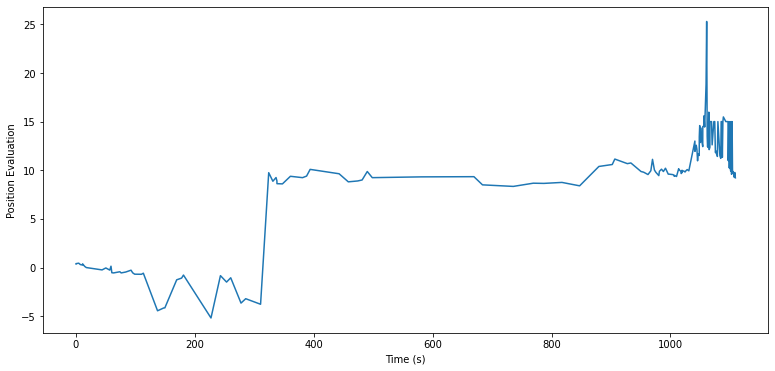

In [50]:
from scipy.interpolate import make_interp_spline
import matplotlib.pyplot as plt

eval = []
for x in range(len(df['evaluation'])):
    if type(df['evaluation'][x]) == float:
        eval.append(df['evaluation'][x])
    elif str(df['evaluation'][x])[1] =='+':
        # pick a good checkmate value
        eval.append(15.0)
    else:
        eval.append(-15.0)

t = np.array([x for x in range(len(df))])
# X_Y_Spline = make_interp_spline(df['real time'], eval)
# X_ = np.linspace(df['real time'].min(), df['real time'].max(), 5000)
# Y_ = X_Y_Spline(X_)
# plt.plot(X_, Y_)
plt.plot(df['real time'], eval)
#plt.plot(t, [0]*len(t), 'black')

plt.xlabel("Time (s)")
plt.ylabel("Position Evaluation")
plt.show()

In [51]:
df[["real time", "evaluation", "move"]].to_csv('file_name.csv')